In [1]:
import dask
import sys
sys.path.append('../cli_common/')
import utils as cli_utils
import histomicstk.preprocessing.color_normalization as htk_cnorm
import large_image
import histomicstk.utils as htk_utils
from skimage.measure import regionprops
from skimage.segmentation import slic
import numpy as np
import h5py

INFO:girder:Created LRU Cache for 'tilesource' with 104 maximum size
INFO:root:Notice: Could not import MapnikTileSource
/home/raj/anaconda2/envs/htkProject/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
def create_dask_client():
    """Create and install a Dask distributed client using args from a
    Namespace, supporting the following attributes:

    - .scheduler_address: Address of the distributed scheduler, or the
      empty string to start one locally

    """
    

    scheduler_address = dask.distributed.LocalCluster(
        ip='0.0.0.0',  # Allow reaching the diagnostics port externally
        scheduler_port=0,  # Don't expose the scheduler port
        silence_logs=False
    )

    return dask.distributed.Client()

In [ ]:
c = create_dask_client()
c

In [3]:
slidePath = 'TCGA.svs'
ts = large_image.getTileSource(slidePath)
# compute colorspace statistics (mean, variance) for whole slide
wsi_mean, wsi_stddev = htk_cnorm.reinhard_stats(slidePath, 0.1, 10)

In [4]:
# compute tissue/foreground mask at low-res for whole slide images
im_fgnd_mask_lres, fgnd_seg_scale = cli_utils.segment_wsi_foreground_at_low_res(ts)

In [5]:
# compute foreground fraction of tiles in parallel using Dask
analysis_tile_size = 2048
analysis_mag = 10
it_kwargs = {
    'tile_size': {'width': analysis_tile_size},
    'scale': {'magnification': analysis_mag},
}

inputSlidePath = 0

tile_fgnd_frac_list = htk_utils.compute_tile_foreground_fraction(
    slidePath, im_fgnd_mask_lres, fgnd_seg_scale,
    **it_kwargs
)

print('\n>> Detecting superpixel data ...\n')


>> Detecting superpixel data ...



In [6]:
def compute_superpixel_data(img_path, tile_position, wsi_mean, wsi_stddev):
    
    # get slide tile source
    ts = large_image.getTileSource(img_path)

    # get requested tile information
    tile_info = ts.getSingleTile(
        tile_position=tile_position,
        resample=True,
        format=large_image.tilesource.TILE_FORMAT_NUMPY)
    
    
    im_tile = tile_info['tile'][:, :, :3]

    reference_mu_lab = [8.63234435, -0.11501964, 0.03868433]
    reference_std_lab = [0.57506023, 0.10403329, 0.01364062]
    
    # perform color normalization
    im_nmzd = htk_cnorm.reinhard(im_tile,
                                 reference_mu_lab, reference_std_lab,
                                 wsi_mean, wsi_stddev)
    patchSize = 32
    # compute the number of super-pixels
    im_width, im_height = im_nmzd.shape[:2]
    n_superpixels = (im_width/patchSize) * (im_height/patchSize)

    #
    # Generate labels using a superpixel algorithm (SLIC)
    # In SLIC, compactness controls image space proximity.
    # Higher compactness will make the shape of superpixels more square.
    #
    
    compactness = 50
    im_label = slic(im_nmzd, n_segments=n_superpixels,
                    compactness=compactness) + 1

    region_props = regionprops(im_label)

    # set superpixel data list
    s_data = []

    for i in range(len(region_props)):
        # get x, y centroids for superpixel
        cen_x, cen_y = region_props[i].centroid

        # get bounds of superpixel region
        min_row, max_row, min_col, max_col = \
            get_patch_bounds(cen_x, cen_y, patchSize, im_width, im_height)

        rgb_data = im_nmzd[min_row:max_row, min_col:max_col]

        s_data.append(rgb_data)

    return s_data

def get_patch_bounds(cx, cy, patch_size, m, n):

    half_patch_size = patch_size/2.0

    min_row = int(round(cx) - half_patch_size)
    max_row = int(round(cx) + half_patch_size)
    min_col = int(round(cy) - half_patch_size)
    max_col = int(round(cy) + half_patch_size)

    if min_row < 0:
        max_row = max_row - min_row
        min_row = 0

    if max_row > m-1:
        min_row = min_row - (max_row - (m-1))
        max_row = m-1

    if min_col < 0:
        max_col = max_col - min_col
        min_col = 0

    if max_col > n-1:
        min_col = min_col - (max_col - (n-1))
        max_col = n-1

    return min_row, max_row, min_col, max_col

In [7]:
tile_result_list = []
min_fgnd_frac = 0.001


for tile in ts.tileIterator(**it_kwargs):
    tile_position = tile['tile_position']['position']
    if tile_fgnd_frac_list[tile_position] <= min_fgnd_frac:
        continue

    # detect superpixel data
    cur_result = dask.delayed(compute_superpixel_data)(
        slidePath,
        tile_position,
        wsi_mean, wsi_stddev)

    # append result to list
    tile_result_list.append(cur_result)

tile_result_list = dask.delayed(tile_result_list).compute()

# initiate output data list
superpixel_data = []

In [8]:
for s_data in tile_result_list:
    for s_d in s_data:
        superpixel_data.append(s_d)

superpixel_data = np.asarray(superpixel_data, dtype=np.float32)

print('>> Writing superpixel data information')

output = h5py.File('superpixelResults', 'w')
output.create_dataset('features', data=superpixel_data)
output.close()

>> Writing superpixel data information


In [9]:
superpixel_data

array([[[[248., 212., 242.],
         [248., 212., 242.],
         [248., 212., 242.],
         ...,
         [249., 213., 240.],
         [249., 213., 242.],
         [249., 213., 243.]],

        [[248., 212., 242.],
         [248., 212., 242.],
         [248., 212., 242.],
         ...,
         [247., 212., 240.],
         [248., 212., 241.],
         [249., 212., 243.]],

        [[248., 212., 242.],
         [248., 212., 242.],
         [248., 212., 242.],
         ...,
         [247., 212., 240.],
         [247., 212., 240.],
         [249., 211., 242.]],

        ...,

        [[249., 213., 241.],
         [248., 212., 242.],
         [249., 212., 243.],
         ...,
         [248., 212., 242.],
         [248., 212., 242.],
         [247., 212., 242.]],

        [[249., 213., 242.],
         [249., 213., 242.],
         [248., 213., 241.],
         ...,
         [248., 212., 242.],
         [248., 212., 242.],
         [247., 213., 244.]],

        [[246., 212., 242.],
       

TypeError: Invalid dimensions for image data

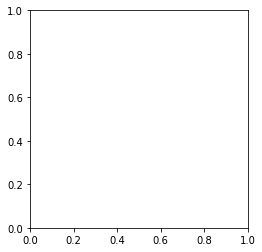

In [11]:
plt.imshow(superpixel_data)
plt.show()

In [10]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
import h5py

In [ ]:
f=h5py.File('TCGAopt','r')
dset=f.keys()

In [ ]:
dset[0]

In [ ]:
dset[1]

In [ ]:
dset[2]

In [ ]:
import numpy as np

In [ ]:
n1=f.get('features')
n1

In [ ]:
n1=np.array(n1)
n1.shape

In [ ]:
print(type(n1))

In [ ]:
print(n1[2])

In [ ]:
print(n1[2])

In [ ]:
print(n1[3])

In [ ]:
print(n1[0])

In [ ]:
n2=f.get('x_centroid')
n2

In [ ]:
n2=np.array(n2)
n2.shape

In [ ]:
print(n2[0])

In [ ]:
print(n2[:15])

In [ ]:
print(n2[16:30])